In [1]:
from sys import path as syspath
from os import path as ospath

syspath.append(ospath.join(ospath.expanduser("~"), 'CBSA'))

from joblib import Parallel, delayed
import pickle
import gc

from cbsa import ReactionSystem
import stochpy as sp
import gillespy2 as glp
import numpy as np
import matplotlib.pyplot as plt
from gillespy2.solvers.numpy.ssa_solver import NumPySSASolver
from gillespy2.solvers.numpy.basic_tau_leaping_solver import BasicTauLeapingSolver


#######################################################################
#                                                                     #
#            Welcome to the interactive StochPy environment           #
#                                                                     #
#######################################################################
#  StochPy: Stochastic modeling in Python                             #
#  http://stochpy.sourceforge.net                                     #
#  Copyright(C) T.R Maarleveld, B.G. Olivier, F.J Bruggeman 2010-2015 #
#  DOI: 10.1371/journal.pone.0079345                                  #
#  Email: tmd200@users.sourceforge.net                                #
#  VU University, Amsterdam, Netherlands                              #
#  Centrum Wiskunde Informatica, Amsterdam, Netherlands               #
#  StochPy is distributed under the BSD licence.                      #
###############################################################

In [30]:
def run_cbsa(switch_k,total_switches):
    
    _total_sim_time = total_switches/switch_k
    _k = [switch_k,switch_k,200,0.5]
    
    S = [[-1,1,0,0],
         [1,-1,0,0],
         [0,0,1,-1]]

    R = [[0,0,1,0],
         [0,0,0,0],
         [0,0,0,0]]

    x = [0,1,0]
    

    max_dt = 0.1
    total_sim_time = _total_sim_time
    alpha=0.5
    
    cbsa = ReactionSystem(S,R)
    cbsa.setup()
    cbsa.set_x(x)
    cbsa.set_k(_k)
    
    cbsa.setup_simulation(use_opencl=False,alpha=alpha,max_dt=max_dt)
    cbsa.compute_simulation(total_sim_time,batch_steps=1)
    cbsa_data = np.array(cbsa.simulation_data)
    
    del cbsa
    
    return cbsa_data

def run_cbsa_dt01(switch_k,total_switches):
    
    _total_sim_time = total_switches/switch_k
    _k = [switch_k,switch_k,200,0.5]
    
    S = [[-1,1,0,0],
         [1,-1,0,0],
         [0,0,1,-1]]

    R = [[0,0,1,0],
         [0,0,0,0],
         [0,0,0,0]]

    x = [0,1,0]
    

    max_dt = 0.01
    total_sim_time = _total_sim_time
    alpha=0.5
    
    cbsa = ReactionSystem(S,R)
    cbsa.setup()
    cbsa.set_x(x)
    cbsa.set_k(_k)
    
    cbsa.setup_simulation(use_opencl=False,alpha=alpha,max_dt=max_dt)
    cbsa.compute_simulation(total_sim_time,batch_steps=1)
    cbsa_data = np.array(cbsa.simulation_data)
    
    del cbsa
    
    return cbsa_data

def run_stochpy_ssa(switch_k,total_switches):
    
    _total_sim_time = total_switches/switch_k
    _k = [switch_k,switch_k,200,0.5]
    
    smod = sp.SSA()
    smod.Model('Burstmodel.psc')
    smod.ChangeParameter("koff",_k[0])
    smod.ChangeParameter("kon",_k[1])
    smod.ChangeParameter("ksyn",_k[2])
    smod.ChangeParameter("kdeg",_k[3])
    smod.ChangeInitialSpeciesCopyNumber("ONstate",0)
    smod.ChangeInitialSpeciesCopyNumber("OFFstate",1)
    smod.ChangeInitialSpeciesCopyNumber("mRNA",0)
    
    smod.DoStochSim(mode='time',end=_total_sim_time,trajectories=1)
    sp_ssa_data = smod.data_stochsim.getSpecies()
    
    del smod
    
    return sp_ssa_data

def run_stochpy_tauleap(switch_k,total_switches):
    
    _total_sim_time = total_switches/switch_k
    _k = [switch_k,switch_k,200,0.5]
    
    smod = sp.SSA()
    smod.Model('Burstmodel.psc')
    smod.ChangeParameter("koff",_k[0])
    smod.ChangeParameter("kon",_k[1])
    smod.ChangeParameter("ksyn",_k[2])
    smod.ChangeParameter("kdeg",_k[3])
    smod.ChangeInitialSpeciesCopyNumber("ONstate",0)
    smod.ChangeInitialSpeciesCopyNumber("OFFstate",1)
    smod.ChangeInitialSpeciesCopyNumber("mRNA",0)
    
    smod.DoStochSim(method='Tauleap',mode='time',end=_total_sim_time,trajectories=1)
    sp_tauleap_data = smod.data_stochsim.getSpecies()
    
    del smod
    
    return sp_tauleap_data

def run_gillespy_ssa(switch_k,total_switches):
    
    _total_sim_time = total_switches/switch_k
    _k = [switch_k,switch_k,200,0.5]
    
    _max_dt=0.1
    gilles = glp.Model(name="Burst")

    k1 = glp.Parameter(name='k1', expression=_k[0])
    k2 = glp.Parameter(name='k2', expression=_k[1])
    k3 = glp.Parameter(name='k3', expression=_k[2])
    k4 = glp.Parameter(name='k4', expression=_k[3])
    gilles.add_parameter([k1,k2,k3,k4])

    m1 = glp.Species(name='Tact', initial_value=0)
    m2 = glp.Species(name='Tinact', initial_value=1)
    m3 = glp.Species(name='P', initial_value=0)
    gilles.add_species([m1,m2,m3])

    r1 = glp.Reaction(name="r1", rate=k1, reactants={m1:1}, products={m2:1})
    r2 = glp.Reaction(name="r2", rate=k2, reactants={m2:1}, products={m1:1})
    r3 = glp.Reaction(name="r3", rate=k3, reactants={m1:1}, products={m3:1,m1:1})
    r4 = glp.Reaction(name="r4", rate=k4, reactants={m3:1}, products={})
    gilles.add_reaction([r1,r2,r3,r4])

    gilles.timespan(np.cumsum(np.array([_max_dt for i in range(int(_total_sim_time/_max_dt))])))
    
    result = gilles.run(solver = NumPySSASolver,number_of_trajectories=1)
    gilles_ssa_data = np.column_stack((result['time'],result['Tact'],result['Tinact'],result['P']))
    
    del result
    del gilles
    
    return gilles_ssa_data

def run_gillespy_tauleap(switch_k,total_switches):
    
    _total_sim_time = total_switches/switch_k
    _k = [switch_k,switch_k,200,0.5]
    
    _max_dt=0.1
    gilles = glp.Model(name="Burst")

    k1 = glp.Parameter(name='k1', expression=_k[0])
    k2 = glp.Parameter(name='k2', expression=_k[1])
    k3 = glp.Parameter(name='k3', expression=_k[2])
    k4 = glp.Parameter(name='k4', expression=_k[3])
    gilles.add_parameter([k1,k2,k3,k4])

    m1 = glp.Species(name='Tact', initial_value=0)
    m2 = glp.Species(name='Tinact', initial_value=1)
    m3 = glp.Species(name='P', initial_value=0)
    gilles.add_species([m1,m2,m3])

    r1 = glp.Reaction(name="r1", rate=k1, reactants={m1:1}, products={m2:1})
    r2 = glp.Reaction(name="r2", rate=k2, reactants={m2:1}, products={m1:1})
    r3 = glp.Reaction(name="r3", rate=k3, reactants={m1:1}, products={m3:1,m1:1})
    r4 = glp.Reaction(name="r4", rate=k4, reactants={m3:1}, products={})
    gilles.add_reaction([r1,r2,r3,r4])

    gilles.timespan(np.cumsum(np.array([_max_dt for i in range(int(_total_sim_time/_max_dt))])))
    
    result = gilles.run(solver = BasicTauLeapingSolver,number_of_trajectories=1)
    gilles_tauleap_data = np.column_stack((result['time'],result['Tact'],result['Tinact'],result['P']))
    
    del result
    del gilles
    
    return gilles_tauleap_data

def run_simulation(info):
    functions = {"CBSA":run_cbsa,
                 "CBSA dt 0.01":run_cbsa_dt01,
                 "StochPy SSA":run_stochpy_ssa,
                 "StochPy Tauleap":run_stochpy_tauleap,
                 "GillesPy SSA":run_gillespy_ssa,
                 "GillesPy Tauleap":run_gillespy_tauleap
                }
    method = info[0]
    param = info[1]
    function = functions[method]
    data = function(*param)
    with open("noise_analysis_data/"+method.replace(" ","_")+"_s"+str(param[0])+"_noise_benchmark.pdata","wb") as f:
        pickle.dump(data,f,protocol=4)
    del data
    gc.collect()
    return True

def get_data(info):
    method = info[0]
    s = str(info[1][0])
    return pickle.load(open("noise_analysis_data/"+method.replace(" ","_")+"_s"+s+"_noise_benchmark.pdata","rb"))

def get_measure(infos,function,**args):
    measures = {}
    for i in range(len(infos)):
        m = infos[i][0]
        s = infos[i][1][0]
        if not m in measures.keys():
            measures[m] = {}
        measures[m][s] = function(get_data(infos[i]),**args)
    return measures

In [3]:
def switch_time_gaps(data):
    tf_str = "".join([str(int(data[i,1])) for i in range(data.shape[0])])
    tf_steps = [step.split("10") for step in tf_str.split("01")]
    tf_steps  = [len(item)+2 for sublist in tf_steps  for item in sublist]
    tf_steps[0] -= 1
    tf_steps[-1] -= 1
    cumsum = [0]+list(np.cumsum(tf_steps))
    time_steps = np.diff(data[:,0])
    tf_times = {0:[],1:[]}
    value = 0
    for i in range(1,len(cumsum)):
        time = np.sum(time_steps[cumsum[i-1]:cumsum[i]])
        tf_times[value].append(time)
        if value:
            value = 0
        else:
            value = 1
    return tf_times

def mean_value(data,index):
    time_steps = np.diff(data[:,0])
    sum_ts = np.sum(time_steps)
    if not sum_ts: return 0.
    return np.sum(time_steps*data[:,index][0:-1])/sum_ts


In [24]:
methods = ["CBSA","CBSA dt 0.01","StochPy SSA","StochPy Tauleap","GillesPy SSA","GillesPy Tauleap"]
switches = [0.01,0.025,0.05,0.075,0.1,0.2,0.3,0.4,0.5]
total_switches = 10000
infos = []
for m in methods:
    for s in switches:
        infos.append([m,(s,total_switches)])

In [14]:
simulations = Parallel(n_jobs=10)(delayed(run_simulation)(i) for i in infos)
np.all(simulations)

True

In [32]:
tf_switch_times = get_measure(infos,switch_time_gaps)
tf_mean_value = get_measure(infos,mean_value,index=1)
P_mean_value = get_measure(infos,mean_value,index=3)

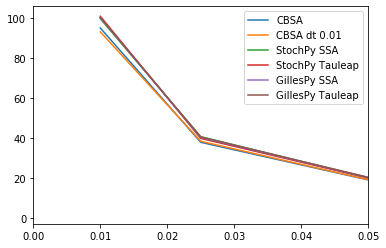

In [74]:
theoretical = np.array([1./s for s in sorted(tf_switch_times["CBSA"].keys())])
plot_methods = ["CBSA","CBSA dt 0.01","StochPy SSA","StochPy Tauleap","GillesPy SSA","GillesPy Tauleap"]

for m in tf_switch_times.keys():
    if m not in plot_methods: continue
    x = sorted(tf_switch_times[m].keys())
    mean_values = [np.mean(tf_switch_times[m][s][0]+tf_switch_times[m][s][1]) for s in x]

#    print(m,np.round(sqr_err.mean()*100,4))
    
    plt.plot(x,mean_values,label=m)

plt.xlim(0,0.05)
plt.legend()
plt.show()

CBSA 6.1956
CBSA dt 0.01 5.7778
StochPy SSA 0.6878
StochPy Tauleap 0.8989
GillesPy SSA 3.5778
GillesPy Tauleap 3.4656


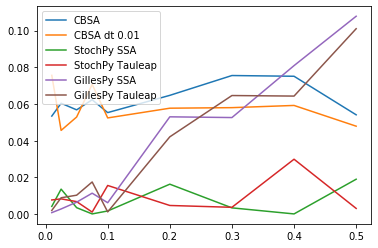

In [68]:
theoretical = np.array([10000 for s in sorted(tf_switch_times["CBSA"].keys())])
plot_methods = ["CBSA","CBSA dt 0.01","StochPy SSA","StochPy Tauleap","GillesPy SSA","GillesPy Tauleap"]

for m in tf_switch_times.keys():
    if m not in plot_methods: continue
    x = sorted(tf_switch_times[m].keys())
    mean_values = [len(tf_switch_times[m][s][0])+len(tf_switch_times[m][s][1]) for s in x]
    sqr_err = np.abs((mean_values-theoretical)/10000)
    print(m,np.round(sqr_err.mean()*100,4))
    
    plt.plot(x,sqr_err,label=m)

#plt.xlim(0,0.075)
plt.legend()
plt.show()

CBSA 1.7225302345341073e-05
CBSA dt 0.01 2.4785266139164256e-05
StochPy SSA 4.2052068866976754e-05
StochPy Tauleap 5.2628892567956596e-05


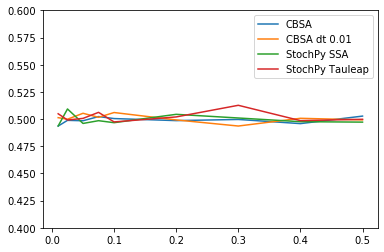

In [44]:
theoretical = np.array([0.5 for s in sorted(tf_mean_value["CBSA"].keys())])
plot_methods = ["CBSA","CBSA dt 0.01","StochPy SSA","StochPy Tauleap"]

for m in tf_mean_value.keys():
    if m not in plot_methods: continue
    x = sorted(tf_mean_value[m].keys())
    y = [tf_mean_value[m][s] for s in x]
    sqr_err = np.square(np.subtract(y, theoretical)).mean()
    print(m,sqr_err/0.5)
    plt.plot(x,y,label=m)

plt.ylim(0.4,0.6)
plt.legend()
plt.show()

CBSA 0.006490688848081978
CBSA dt 0.01 0.01103830732466738
StochPy SSA 0.016808732483857877
StochPy Tauleap 0.019852275140732435


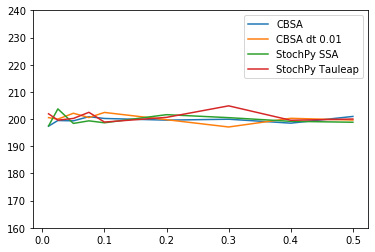

In [69]:
theoretical = np.array([200 for s in sorted(P_mean_value["CBSA"].keys())])
plot_methods = ["CBSA","CBSA dt 0.01","StochPy SSA","StochPy Tauleap"]

for m in tf_mean_value.keys():
    if m not in plot_methods: continue
    x = sorted(tf_mean_value[m].keys())
    y = [P_mean_value[m][s] for s in x]
    sqr_err = np.square(np.subtract(y, theoretical)).mean()
    print(m,sqr_err/200)
    plt.plot(x,y,label=m)

plt.ylim(160,240)
plt.legend()
plt.show()